## Forecasting Germany Electricity Load (15 minute intervals)
* We will use the LSTM model

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import datetime as dt



In [2]:
# Reading 15 min frequency dataset
url = 'https://data.open-power-system-data.org/time_series/2020-10-06/time_series_15min_singleindex.csv'
df = pd.read_csv(url)
display(df.head())

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,DE_load_actual_entsoe_transparency,...,HU_solar_generation_actual,HU_wind_onshore_generation_actual,LU_load_actual_entsoe_transparency,LU_load_forecast_entsoe_transparency,NL_load_actual_entsoe_transparency,NL_load_forecast_entsoe_transparency,NL_solar_generation_actual,NL_wind_generation_actual,NL_wind_offshore_generation_actual,NL_wind_onshore_generation_actual
0,2014-12-31T23:00:00Z,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-31T23:15:00Z,2015-01-01T00:15:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-31T23:30:00Z,2015-01-01T00:30:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-12-31T23:45:00Z,2015-01-01T00:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01T00:00:00Z,2015-01-01T01:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df = df[['utc_timestamp',
    'DE_load_actual_entsoe_transparency', #Total load in Germany in MW as published on ENTSO-E Transparency Platform
    'DE_solar_capacity', # Electrical capacity of solar in Germany in MW
    'DE_solar_generation_actual', #Actual solar generation in Germany in MW
    'DE_solar_profile', #Share of solar capacity producing in Germany
    'DE_wind_capacity', # Electrical capacity of wind in Germany in MW
    'DE_wind_generation_actual', #Actual wind generation in Germany in MW
    'DE_wind_profile', # Share of wind capacity producing in Germany
    'DE_wind_offshore_capacity', #Electrical capacity of wind_offshore in Germany in MW
    'DE_wind_offshore_generation_actual', # Actual wind_offshore generation in Germany in MW
    'DE_wind_offshore_profile', #Share of wind_offshore capacity producing in Germany
    'DE_wind_onshore_capacity', #Electrical capacity of wind_onshore in Germany in MW
    'DE_wind_onshore_generation_actual', #Actual wind_onshore generation in Germany in MW
    'DE_wind_onshore_profile' #Share of wind_onshore capacity producing in Germany
    ]]

In [4]:
df.shape

(201604, 14)

In [5]:
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df = df.set_index('utc_timestamp')

print("Missing values in 'DE_load_actual_entsoe_transparency' before handling:")
print(df['DE_load_actual_entsoe_transparency'].isnull().sum())

df['DE_load_actual_entsoe_transparency'] = df['DE_load_actual_entsoe_transparency'].ffill().bfill()

print("\nMissing values in 'DE_load_actual_entsoe_transparency' after handling:")
print(df['DE_load_actual_entsoe_transparency'].isnull().sum())

df.head()

Missing values in 'DE_load_actual_entsoe_transparency' before handling:
6

Missing values in 'DE_load_actual_entsoe_transparency' after handling:
0


,DE_load_actual_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile
utc_timestamp,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,41517.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31 23:15:00+00:00,41517.72,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,NaN,27246.0,NaN,NaN
2014-12-31 23:30:00+00:00,41517.72,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,NaN,27246.0,NaN,NaN
2014-12-31 23:45:00+00:00,41517.72,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,NaN,27246.0,NaN,NaN
2015-01-01 00:00:00+00:00,41517.72,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,NaN,27246.0,NaN,NaN


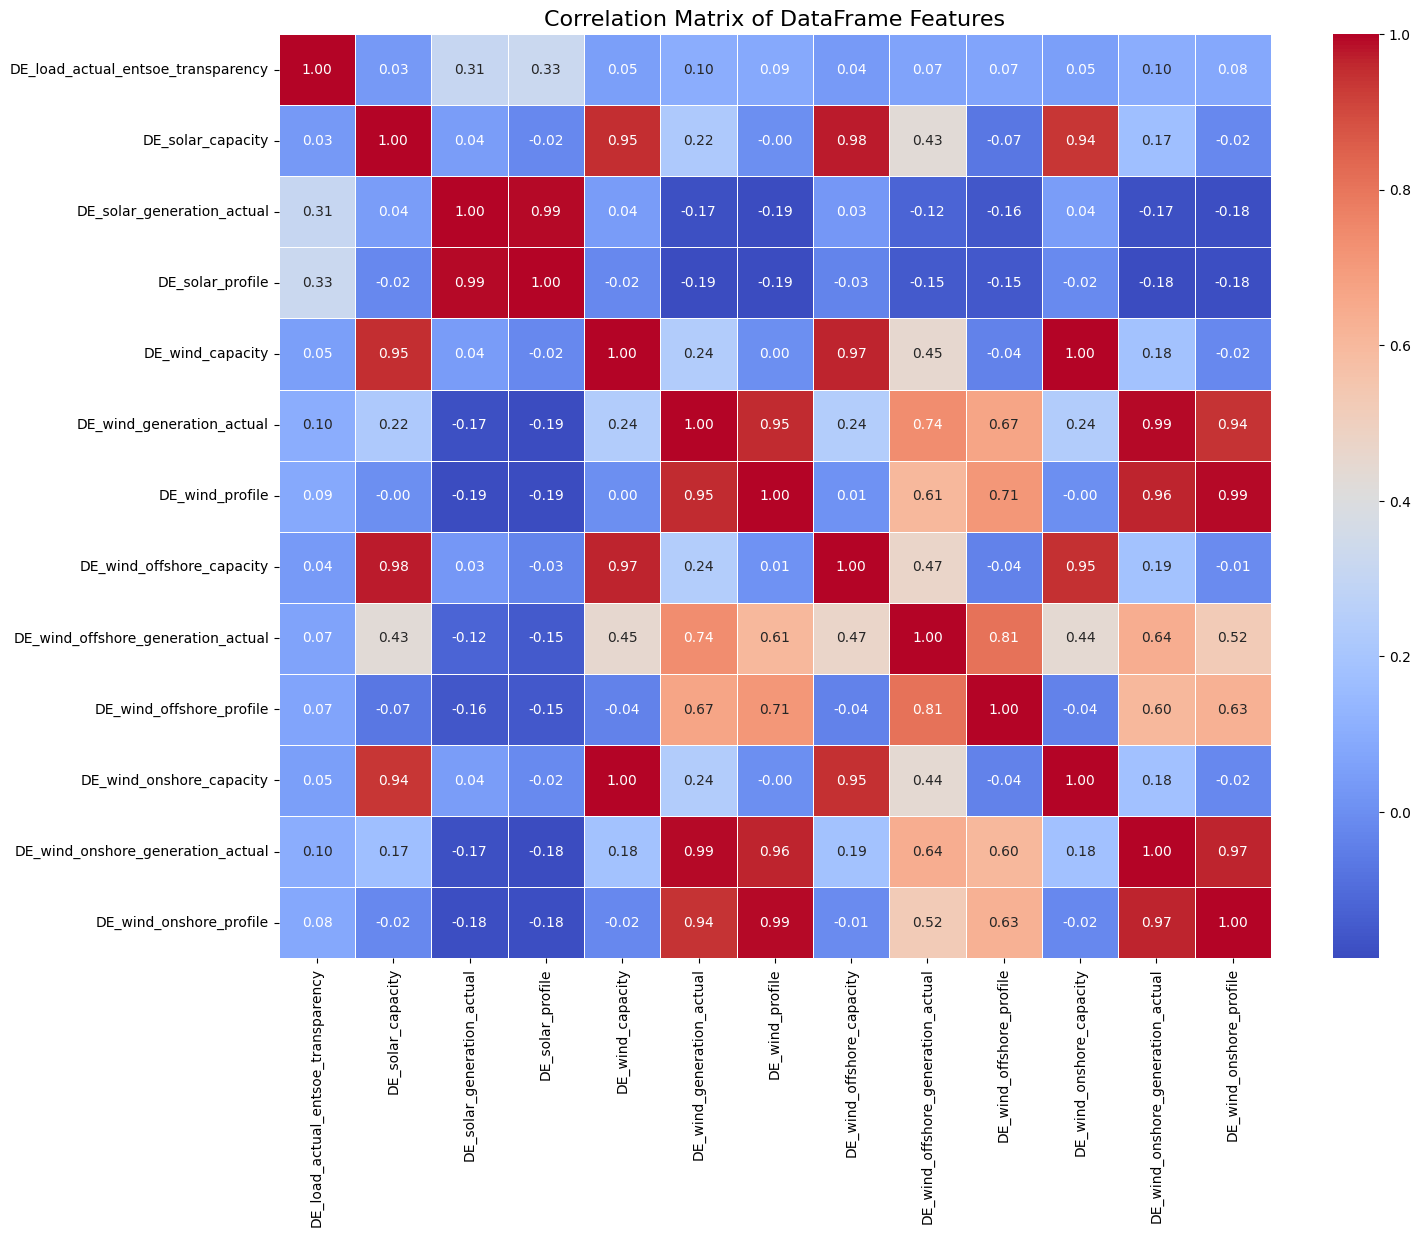

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of DataFrame Features', fontsize=16)
plt.show()

In [7]:
target_variable = 'DE_load_actual_entsoe_transparency'



In [8]:
from typing import List

def get_columns_to_remove_collinearity(X: pd.DataFrame, threshold: float = 0.9) -> List[str]:
    """
    Identifies column names to remove from a DataFrame of independent variables
    to reduce multicollinearity. It keeps the first variable of a highly
    correlated pair and drops the second.

    Args:
        X (pd.DataFrame): DataFrame containing only independent features.
        threshold (float): The absolute correlation threshold (e.g., 0.9) to use.

    Returns:
        List[str]: A list of column names to drop.
    """
    # Calculate the correlation matrix
    corr_matrix = X.corr().abs()

    # Select the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Initialize a set to store the names of features to drop
    to_drop = set()

    # Iterate over the columns of the upper triangle
    for column in upper.columns:
        # Find features in the current column that exceed the threshold
        high_corr_features = upper[column][upper[column] > threshold].index

        for feature in high_corr_features:
            # Add the second feature of the highly correlated pair to the drop list
            if feature not in to_drop and column not in to_drop:
                to_drop.add(feature)

    return list(to_drop)



# Create X (features) by dropping the target column
X_df = df.drop(columns=[target_variable])

highly_correlated_features = get_columns_to_remove_collinearity(X_df, threshold=0.9)


In [9]:
df_filtered = df.drop(columns=highly_correlated_features, errors='ignore')

print(f"Shape of the DataFrame after removing highly correlated features: {df_filtered.shape}")


Shape of the DataFrame after removing highly correlated features: (201604, 6)


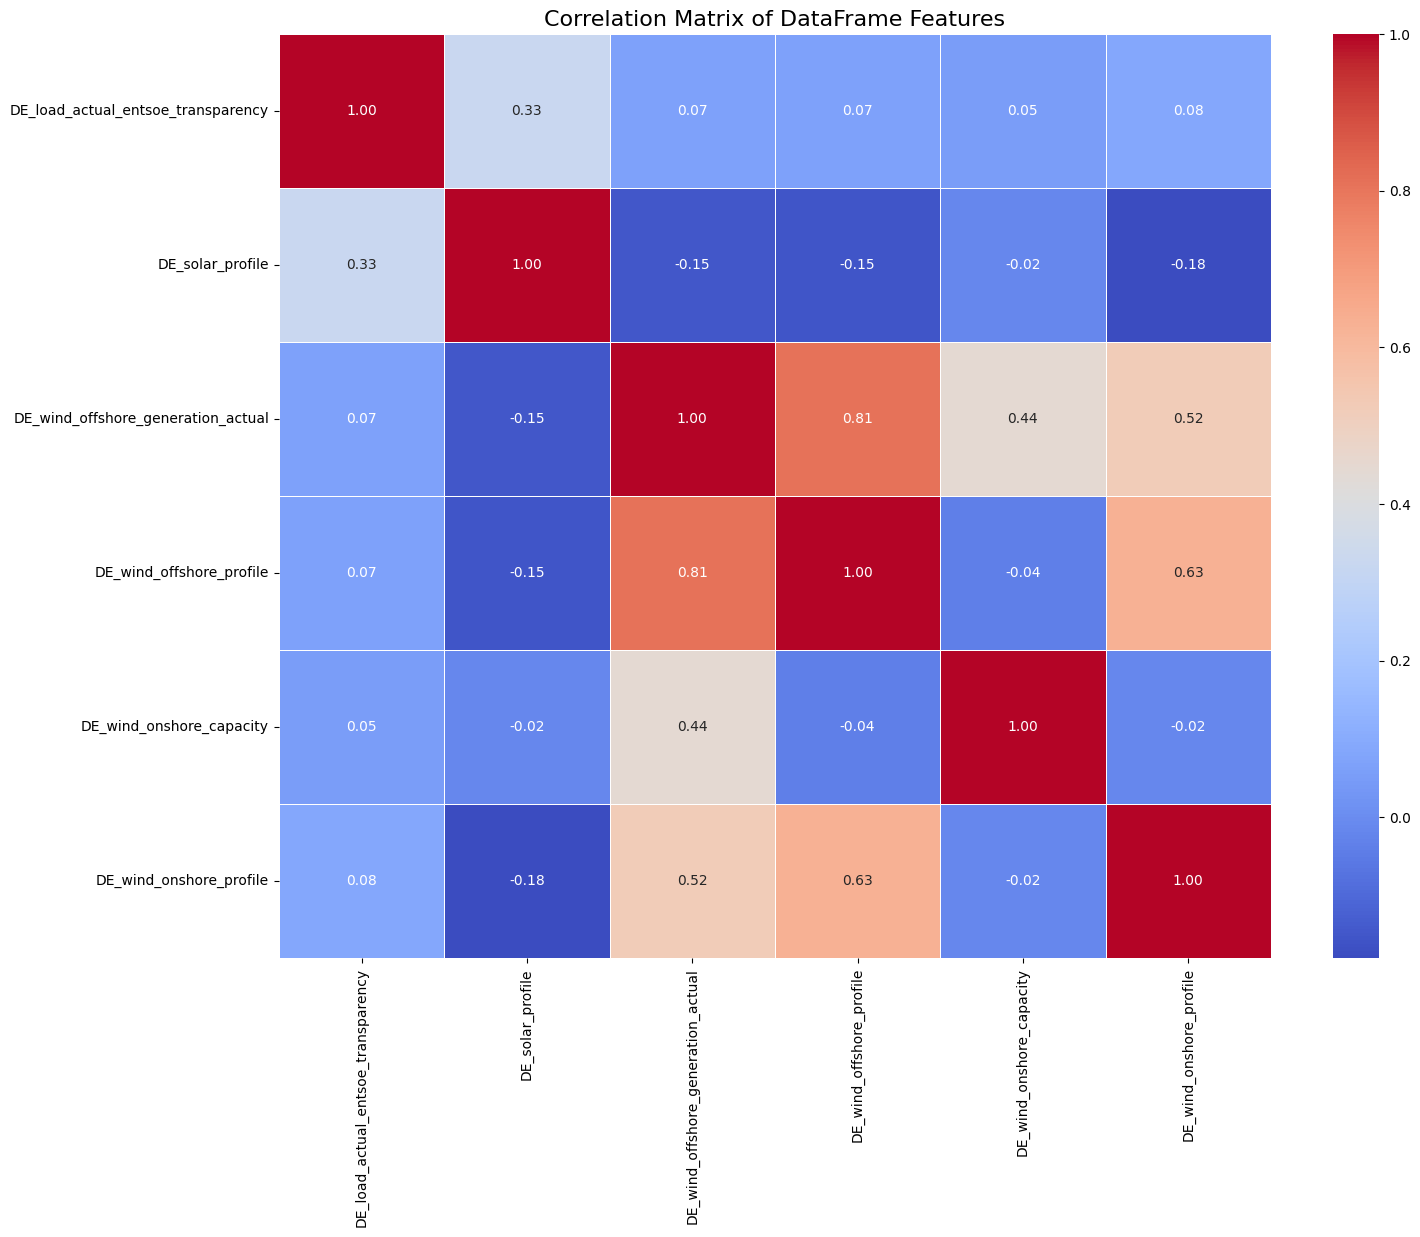

In [10]:
# Calculate the correlation matrix
correlation_matrix_2 = df_filtered.corr()

# Create a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix_2, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of DataFrame Features', fontsize=16)
plt.show()

In [11]:
# Create lag features
for i in range(1, 5):
    df_filtered[f'{target_variable}_lag_{i}'] = df_filtered[target_variable].shift(i)

print("DataFrame with lag features:")
display(df_filtered.head())

DataFrame with lag features:


,DE_load_actual_entsoe_transparency,DE_solar_profile,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_profile,DE_load_actual_entsoe_transparency_lag_1,DE_load_actual_entsoe_transparency_lag_2,DE_load_actual_entsoe_transparency_lag_3,DE_load_actual_entsoe_transparency_lag_4
utc_timestamp,,,,,,,,,,
2014-12-31 23:00:00+00:00,41517.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31 23:15:00+00:00,41517.72,NaN,NaN,NaN,27246.0,NaN,41517.72,NaN,NaN,NaN
2014-12-31 23:30:00+00:00,41517.72,NaN,NaN,NaN,27246.0,NaN,41517.72,41517.72,NaN,NaN
2014-12-31 23:45:00+00:00,41517.72,NaN,NaN,NaN,27246.0,NaN,41517.72,41517.72,41517.72,NaN
2015-01-01 00:00:00+00:00,41517.72,NaN,NaN,NaN,27246.0,NaN,41517.72,41517.72,41517.72,41517.72


In [12]:
df_filtered[f'{target_variable}_MA_4'] = df_filtered[target_variable].rolling(window=4).mean()
df_filtered[f'{target_variable}_MA_24'] = df_filtered[target_variable].rolling(window=24).mean()

print("DataFrame with moving average features:")
display(df_filtered.head())

DataFrame with moving average features:


,DE_load_actual_entsoe_transparency,DE_solar_profile,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_profile,DE_load_actual_entsoe_transparency_lag_1,DE_load_actual_entsoe_transparency_lag_2,DE_load_actual_entsoe_transparency_lag_3,DE_load_actual_entsoe_transparency_lag_4,DE_load_actual_entsoe_transparency_MA_4,DE_load_actual_entsoe_transparency_MA_24
utc_timestamp,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,41517.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31 23:15:00+00:00,41517.72,NaN,NaN,NaN,27246.0,NaN,41517.72,NaN,NaN,NaN,NaN,NaN
2014-12-31 23:30:00+00:00,41517.72,NaN,NaN,NaN,27246.0,NaN,41517.72,41517.72,NaN,NaN,NaN,NaN
2014-12-31 23:45:00+00:00,41517.72,NaN,NaN,NaN,27246.0,NaN,41517.72,41517.72,41517.72,NaN,41517.72,NaN
2015-01-01 00:00:00+00:00,41517.72,NaN,NaN,NaN,27246.0,NaN,41517.72,41517.72,41517.72,41517.72,41517.72,NaN


In [13]:
df_filtered['hour'] = df_filtered.index.hour
df_filtered['dayofweek'] = df_filtered.index.dayofweek
df_filtered['month'] = df_filtered.index.month
df_filtered['year'] = df_filtered.index.year
df_filtered['quarter'] = df_filtered.index.quarter
df_filtered['dayofyear'] = df_filtered.index.dayofyear
df_filtered['weekofyear'] = df_filtered.index.isocalendar().week.astype(int)

In [14]:
# Drop NaN values introduced by lag and moving average calculations
df_filtered.dropna(inplace=True)


In [15]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical features for scaling. Exclude non-numerical columns if any.
# Assuming all columns in the current df are numeric or should be scaled, except the index.
features_to_scale = df_filtered.columns.tolist()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the selected features and transform them
df_scaled = pd.DataFrame(scaler.fit_transform(df_filtered[features_to_scale]), columns=features_to_scale, index=df_filtered.index)

print("Scaled DataFrame (first 5 rows):")
display(df_scaled.head())

print("\nScaled DataFrame (last 5 rows):")
display(df_scaled.tail())

Scaled DataFrame (first 5 rows):


,DE_load_actual_entsoe_transparency,DE_solar_profile,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_profile,DE_load_actual_entsoe_transparency_lag_1,DE_load_actual_entsoe_transparency_lag_2,DE_load_actual_entsoe_transparency_lag_3,DE_load_actual_entsoe_transparency_lag_4,DE_load_actual_entsoe_transparency_MA_4,DE_load_actual_entsoe_transparency_MA_24,hour,dayofweek,month,year,quarter,dayofyear,weekofyear
utc_timestamp,,,,,,,,,,,,,,,,,,,
2015-01-01 07:15:00+00:00,0.243149,0.000579,0.075942,0.524086,0.0,0.328118,0.241858,0.235789,0.229736,0.223931,0.203946,0.171861,0.304348,0.5,0.0,0.0,0.0,0.0,0.0
2015-01-01 07:30:00+00:00,0.245668,0.001883,0.076168,0.525687,0.0,0.315383,0.243149,0.241858,0.235789,0.229736,0.208129,0.172942,0.304348,0.5,0.0,0.0,0.0,0.0,0.0
2015-01-01 07:45:00+00:00,0.252969,0.005794,0.076430,0.527489,0.0,0.312290,0.245668,0.243149,0.241858,0.235789,0.212641,0.174701,0.304348,0.5,0.0,0.0,0.0,0.0,0.0
2015-01-01 08:00:00+00:00,0.266194,0.013326,0.076423,0.527422,0.0,0.309106,0.252969,0.245668,0.243149,0.241858,0.219031,0.177219,0.347826,0.5,0.0,0.0,0.0,0.0,0.0
2015-01-01 08:15:00+00:00,0.276545,0.022306,0.076438,0.527555,0.0,0.315746,0.266194,0.252969,0.245668,0.243149,0.227801,0.180459,0.347826,0.5,0.0,0.0,0.0,0.0,0.0



Scaled DataFrame (last 5 rows):


,DE_load_actual_entsoe_transparency,DE_solar_profile,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_profile,DE_load_actual_entsoe_transparency_lag_1,DE_load_actual_entsoe_transparency_lag_2,DE_load_actual_entsoe_transparency_lag_3,DE_load_actual_entsoe_transparency_lag_4,DE_load_actual_entsoe_transparency_MA_4,DE_load_actual_entsoe_transparency_MA_24,hour,dayofweek,month,year,quarter,dayofyear,weekofyear
utc_timestamp,,,,,,,,,,,,,,,,,,,
2019-12-30 21:45:00+00:00,0.419923,0.0,0.750471,0.601681,1.0,0.529428,0.431484,0.446962,0.460791,0.459326,0.416287,0.528566,0.913043,0.0,1.0,1.0,1.0,0.994521,0.0
2019-12-30 22:00:00+00:00,0.405690,0.0,0.751258,0.602282,1.0,0.528791,0.419923,0.431484,0.446962,0.460791,0.401818,0.520191,0.956522,0.0,1.0,1.0,1.0,0.994521,0.0
2019-12-30 22:15:00+00:00,0.379727,0.0,0.749271,0.600681,1.0,0.519603,0.405690,0.419923,0.431484,0.446962,0.384162,0.510025,0.956522,0.0,1.0,1.0,1.0,0.994521,0.0
2019-12-30 22:30:00+00:00,0.361274,0.0,0.744449,0.596811,1.0,0.513236,0.379727,0.405690,0.419923,0.431484,0.365725,0.498838,0.956522,0.0,1.0,1.0,1.0,0.994521,0.0
2019-12-30 22:45:00+00:00,0.350279,0.0,0.733059,0.587670,1.0,0.510143,0.361274,0.379727,0.405690,0.419923,0.347437,0.487144,0.956522,0.0,1.0,1.0,1.0,0.994521,0.0


In [16]:
intervals_per_hour = 60 / 15 # 4 15-minute intervals per hour
hours_per_day = 24
days_per_month = 30
months = 3

forecast_horizon = int(months * days_per_month * hours_per_day * intervals_per_hour)

print(f"Calculated forecast horizon (number of 15-minute intervals for 3 months): {forecast_horizon}")

Calculated forecast horizon (number of 15-minute intervals for 3 months): 8640


In [17]:
test_set_size = forecast_horizon

train_df = df_scaled.iloc[:-test_set_size]
test_df = df_scaled.iloc[-test_set_size:]

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

display(train_df.head())
display(test_df.head())

Training set shape: (166133, 19)
Test set shape: (8640, 19)


,DE_load_actual_entsoe_transparency,DE_solar_profile,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_profile,DE_load_actual_entsoe_transparency_lag_1,DE_load_actual_entsoe_transparency_lag_2,DE_load_actual_entsoe_transparency_lag_3,DE_load_actual_entsoe_transparency_lag_4,DE_load_actual_entsoe_transparency_MA_4,DE_load_actual_entsoe_transparency_MA_24,hour,dayofweek,month,year,quarter,dayofyear,weekofyear
utc_timestamp,,,,,,,,,,,,,,,,,,,
2015-01-01 07:15:00+00:00,0.243149,0.000579,0.075942,0.524086,0.0,0.328118,0.241858,0.235789,0.229736,0.223931,0.203946,0.171861,0.304348,0.5,0.0,0.0,0.0,0.0,0.0
2015-01-01 07:30:00+00:00,0.245668,0.001883,0.076168,0.525687,0.0,0.315383,0.243149,0.241858,0.235789,0.229736,0.208129,0.172942,0.304348,0.5,0.0,0.0,0.0,0.0,0.0
2015-01-01 07:45:00+00:00,0.252969,0.005794,0.076430,0.527489,0.0,0.312290,0.245668,0.243149,0.241858,0.235789,0.212641,0.174701,0.304348,0.5,0.0,0.0,0.0,0.0,0.0
2015-01-01 08:00:00+00:00,0.266194,0.013326,0.076423,0.527422,0.0,0.309106,0.252969,0.245668,0.243149,0.241858,0.219031,0.177219,0.347826,0.5,0.0,0.0,0.0,0.0,0.0
2015-01-01 08:15:00+00:00,0.276545,0.022306,0.076438,0.527555,0.0,0.315746,0.266194,0.252969,0.245668,0.243149,0.227801,0.180459,0.347826,0.5,0.0,0.0,0.0,0.0,0.0


,DE_load_actual_entsoe_transparency,DE_solar_profile,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_profile,DE_load_actual_entsoe_transparency_lag_1,DE_load_actual_entsoe_transparency_lag_2,DE_load_actual_entsoe_transparency_lag_3,DE_load_actual_entsoe_transparency_lag_4,DE_load_actual_entsoe_transparency_MA_4,DE_load_actual_entsoe_transparency_MA_24,hour,dayofweek,month,year,quarter,dayofyear,weekofyear
utc_timestamp,,,,,,,,,,,,,,,,,,,
2019-10-01 23:00:00+00:00,0.353315,0.0,0.480757,0.390179,0.982364,0.211498,0.348058,0.351806,0.359578,0.367466,0.325323,0.536478,1.0,0.166667,0.818182,1.0,1.0,0.747945,0.75
2019-10-01 23:15:00+00:00,0.347073,0.0,0.520343,0.422338,0.982364,0.212590,0.353315,0.348058,0.351806,0.359578,0.322039,0.517918,1.0,0.166667,0.818182,1.0,1.0,0.747945,0.75
2019-10-01 23:30:00+00:00,0.341971,0.0,0.481057,0.390446,0.982364,0.214864,0.347073,0.353315,0.348058,0.351806,0.319457,0.499096,1.0,0.166667,0.818182,1.0,1.0,0.747945,0.75
2019-10-01 23:45:00+00:00,0.334688,0.0,0.406292,0.329730,0.982364,0.214955,0.341971,0.347073,0.353315,0.348058,0.315946,0.480333,1.0,0.166667,0.818182,1.0,1.0,0.747945,0.75
2019-10-02 00:00:00+00:00,0.337511,0.0,0.394929,0.320523,0.982364,0.216501,0.334688,0.341971,0.347073,0.353315,0.311796,0.462706,0.0,0.333333,0.818182,1.0,1.0,0.750685,0.75


In [18]:
import numpy as np

# 1. Define the input and output sequence lengths
look_back_window = 24 # 6 hours of past data (24 * 15min intervals)
forecast_window = 1   # Predict the next 15-minute interval

# 2. Create a function, create_sequences
def create_sequences(data, look_back_window, forecast_window, target_idx):
    X, y = [], []
    for i in range(len(data) - look_back_window - forecast_window + 1):
        X.append(data[i:(i + look_back_window), :])
        y.append(data[(i + look_back_window):(i + look_back_window + forecast_window), target_idx])
    return np.array(X), np.array(y)

print(f"Defined look_back_window: {look_back_window}")
print(f"Defined forecast_window: {forecast_window}")
print("create_sequences function defined.")

Defined look_back_window: 24
Defined forecast_window: 1
create_sequences function defined.


In [19]:
target_variable = 'DE_load_actual_entsoe_transparency'
target_idx = df_scaled.columns.get_loc(target_variable)

# Apply create_sequences to training data
X_train, y_train = create_sequences(train_df.values, look_back_window, forecast_window, target_idx)

# Apply create_sequences to testing data
X_test, y_test = create_sequences(test_df.values, look_back_window, forecast_window, target_idx)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (166109, 24, 19)
Shape of y_train: (166109, 1)
Shape of X_test: (8616, 24, 19)
Shape of y_test: (8616, 1)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print("Keras models and layers imported successfully.")

Keras models and layers imported successfully.


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(look_back_window, X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=forecast_window)
])

model.compile(optimizer='adam', loss='mean_squared_error')

print("Model architecture:")
model.summary()

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping])

print("Model training complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        14,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,251 (133.79 KB)

 Trainable params: 34,251 (133.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4672/4672 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 0.0062 - val_loss: 2.4811e-04
Epoch 2/50
4672/4672 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - loss: 6.4324e-04 - val_loss: 1.0907e-04
Epoch 3/50
4672/4672 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 4.5436e-04 - val_loss: 1.5225e-04
Epoch 4/50
4672/4672 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 4.0627e-04 - val_loss: 8.1483e-05
Epoch 5/50
4672/4672 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 3.8747e-04 - val_loss: 7.2050e-05
Epoch 6/50
4672/4672 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 3.7617e-04 - val_loss: 8.7443e-05
Epoch 7/50
4672/4672 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 3.7086e-04 - val_loss: 7.6134e-05
Epoch 8/50
4672/4672 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 3.6062e-04 - val_loss: 8.4545e-05
Epoch 9/50
4672/4672 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 3.6335e-04 - val_loss: 5.3361e-05
Epoch 10/50
4672/4672 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 3.5155e-04 - val_loss: 9.5993e-05
Epoch 11/50
4672/4672 ━━━━━━━━━━━

In [22]:
iterative_predictions = []

# Get the last `look_back_window` rows from train_df to initialize the input sequence
# Make a copy to avoid modifying the original train_df values in place
current_input_sequence = train_df.values[-look_back_window:].copy()

num_features = X_train.shape[2] # Number of features in the dataset

print(f"Starting iterative forecasting for {len(test_df)} steps...")

for i in range(len(test_df) - forecast_window + 1):
    # a. Reshape current_input_sequence for prediction
    # The model expects input in the shape (batch_size, look_back_window, num_features)
    reshaped_input = current_input_sequence.reshape(1, look_back_window, num_features)

    # b. Use the trained model to predict the next step
    predicted_scaled_value = model.predict(reshaped_input, verbose=0)[0][0]

    # c. Append predicted_scaled_value to the iterative_predictions list
    iterative_predictions.append(predicted_scaled_value)

    # d. Prepare the data for the next input sequence
    # Get actual scaled features for the current test step
    next_timestep_actual_features = test_df.iloc[i].values.copy()
    # Replace the actual target value with the predicted target value
    next_timestep_actual_features[target_idx] = predicted_scaled_value

    # e. Update current_input_sequence
    # Remove the first row (oldest time step) and append the new data
    current_input_sequence = np.vstack([current_input_sequence[1:], next_timestep_actual_features])

# 4. Convert the iterative_predictions list into a NumPy array
iterative_predictions_array = np.array(iterative_predictions)

# 5. Reshape the iterative_predictions array to (-1, 1)
iterative_predictions_array = iterative_predictions_array.reshape(-1, 1)

print("Iterative forecasting complete.")
print(f"Shape of iterative_predictions_array: {iterative_predictions_array.shape}")


Starting iterative forecasting for 8640 steps...
Iterative forecasting complete.
Shape of iterative_predictions_array: (8640, 1)


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Inverse transform the scaled actual test values (y_test) and iterative predictions

# Create dummy arrays for inverse transformation
y_test_inverse_transform_dummy = np.zeros((len(y_test), num_features))
iterative_predictions_inverse_transform_dummy = np.zeros((len(iterative_predictions_array), num_features))

# Place the scaled target values into the target column of the dummy arrays
y_test_inverse_transform_dummy[:, target_idx] = y_test.flatten()
iterative_predictions_inverse_transform_dummy[:, target_idx] = iterative_predictions_array.flatten()

# Inverse transform the dummy arrays
y_test_original = scaler.inverse_transform(y_test_inverse_transform_dummy)[:, target_idx]
iterative_predictions_original = scaler.inverse_transform(iterative_predictions_inverse_transform_dummy)[:, target_idx]

# Align iterative_predictions_original with y_test_original
# y_test_original starts at the point where look_back_window data points have passed in test_df
# iterative_predictions_original includes predictions for these initial look_back_window points.
# We slice iterative_predictions_original to match the length and start of y_test_original.
iterative_predictions_original_aligned = iterative_predictions_original[look_back_window:]

# 2. Calculate MAE
mae = mean_absolute_error(y_test_original, iterative_predictions_original_aligned)

# 3. Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, iterative_predictions_original_aligned))

# 4. Print the calculated MAE and RMSE values
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 647.71
Root Mean Squared Error (RMSE): 830.60


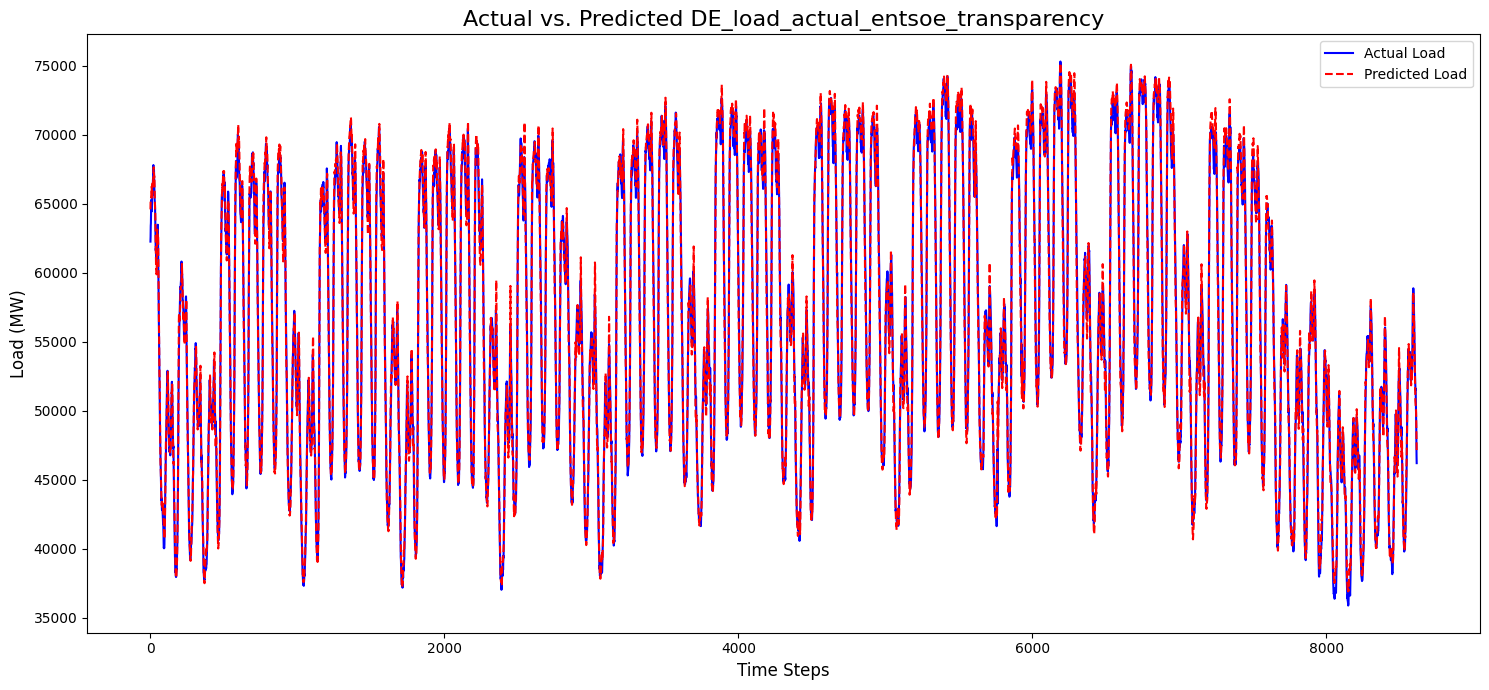

In [24]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

# Plot actual values
ax.plot(y_test_original, label='Actual Load', color='blue')

# Plot predicted values
ax.plot(iterative_predictions_original_aligned, label='Predicted Load', color='red', linestyle='--')

# Add title and labels
ax.set_title('Actual vs. Predicted DE_load_actual_entsoe_transparency', fontsize=16)
ax.set_xlabel('Time Steps', fontsize=12)
ax.set_ylabel('Load (MW)', fontsize=12)

# Add legend
ax.legend(fontsize=10)

# Ensure all elements fit within the figure
plt.tight_layout()

# Display the plot
plt.show()